In [75]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset
import csv
from PIL import Image
import re
from torchsummary import summary

cudnn.benchmark = True
plt.ion()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dataset

In [76]:
class CustomDataset(Dataset):
    def __init__(self, path, transform=None):
        super().__init__()
        self.transform = transform
        self.main_dir = os.path.join(path)
        self.all_imgs = sorted(os.listdir(self.main_dir), key=lambda s: int(re.search(r'\d+', s).group()))
        
    def __len__(self):
        return len(self.all_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

Device

In [77]:
#apple
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#windows
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Load Data

In [78]:

data_transforms =  transforms.Compose([
        transforms.Resize((512,512)),
        transforms.ToTensor(),
    ])
directory = os.getcwd()
data_dir = 'D:/Uni_Sem3/DL/DL/screw/train/good/'
train_dataset = CustomDataset(data_dir,data_transforms)
test_dataset = CustomDataset('D:/Uni_Sem3/DL/DL/screw/test/scratch_head',data_transforms)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

val_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                             shuffle=False, num_workers=0)

test_dataloader =  torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                             shuffle=False, num_workers=0)

print(len(train_dataloader),len(val_dataloader),len(test_dataloader))

64 16 24


View Data

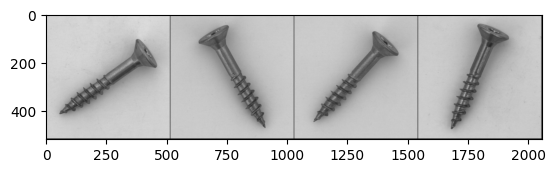

In [79]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of  data
inputs = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

Datasets & DataLoaders

In [80]:
image_datasets = {'train': train_dataset }
dataloaders = {'train': train_dataloader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}


Encoder

In [81]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(256),
            nn.Flatten(),
            nn.Linear(256*13*13, 40),#13*13  #29*29
        )    
        
        self.decoder = nn.Sequential(
            nn.Linear(40, 256*13*13),
            nn.Unflatten(dim=1, unflattened_size=(256, 13, 13)),
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, 2, 1, bias=True),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 4, 2, 1, bias=True),
            nn.ReLU(True)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        x = self.encoder(x)
        return x
    

In [82]:
testModel = AutoEncoder()
#summary(testModel, (3, 512, 512),4)


Model, Loss & Optimizer

In [83]:
torch.manual_seed(0)

loss = torch.nn.MSELoss()
lr= 0.001
num_epochs = 50

model = AutoEncoder()
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-05)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=num_epochs * len(train_dataloader),
#                                                        eta_min= 1e-6/lr)

model.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)

Train

In [84]:
def train_epoch(model, device, dataloader, loss_fn, optimizer): # add scheduler

    model.train()
    train_loss = []
    for image_batch in dataloader: 
        image_batch = image_batch.to(device)
        decoded_data = model(image_batch)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
        #print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

Validation Test

In [85]:
def test_epoch(model, device, dataloader, loss_fn):
    model.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model(image_batch)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

Plot Output

In [86]:
def plot_ae_outputs(model,n=10):
  # inputs = next(iter(val_dataloader))
  # out = torchvision.utils.make_grid(inputs)
  # imshow(out)
  img = inputs.to(device)
  model.eval()
  with torch.no_grad():
      rec_img  = model(img)
  rec_img = rec_img.cpu()
  rec_out =  torchvision.utils.make_grid(rec_img)
  imshow(rec_out)

Training


 EPOCH 1/50 	 train loss 0.19526052474975586 	 val loss 0.04886789619922638


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


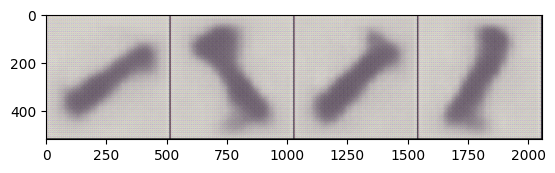


 EPOCH 2/50 	 train loss 0.015276344493031502 	 val loss 0.007176124956458807


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


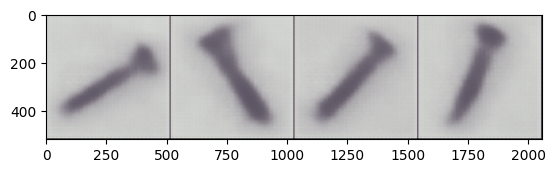


 EPOCH 3/50 	 train loss 0.005097890272736549 	 val loss 0.004107759799808264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


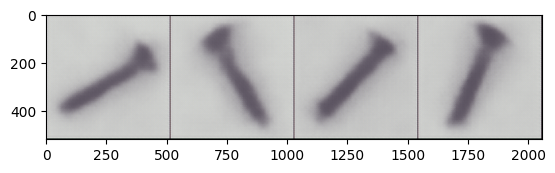


 EPOCH 4/50 	 train loss 0.0038025309331715107 	 val loss 0.003476219018921256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


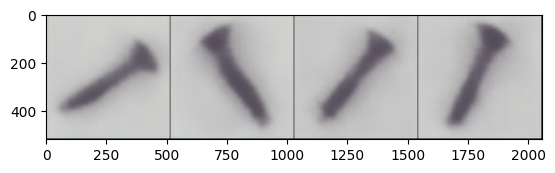


 EPOCH 5/50 	 train loss 0.0033091562800109386 	 val loss 0.003064986551180482


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


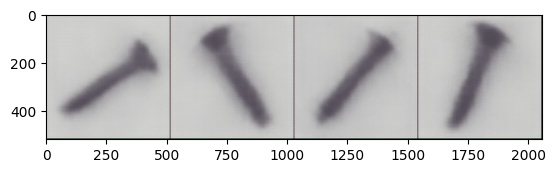


 EPOCH 6/50 	 train loss 0.003033390734344721 	 val loss 0.0029382582288235426


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


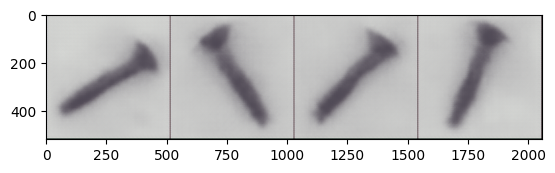


 EPOCH 7/50 	 train loss 0.0027845720760524273 	 val loss 0.0026431733276695013


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


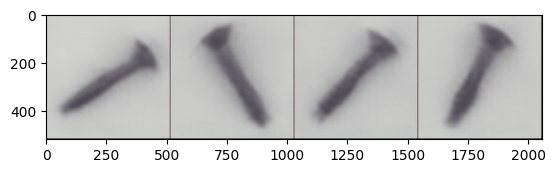


 EPOCH 8/50 	 train loss 0.0026237124111503363 	 val loss 0.0028084812220185995


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


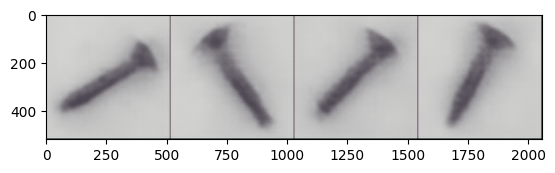


 EPOCH 9/50 	 train loss 0.002667956752702594 	 val loss 0.002425840124487877


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


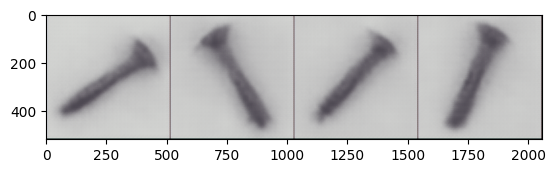


 EPOCH 10/50 	 train loss 0.0024014138616621494 	 val loss 0.0022785672917962074


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


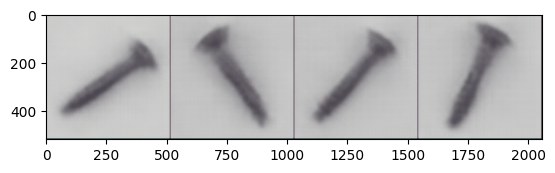


 EPOCH 11/50 	 train loss 0.002161545678973198 	 val loss 0.002177347196266055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


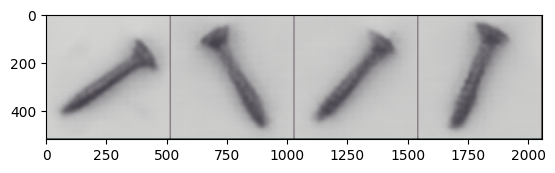


 EPOCH 12/50 	 train loss 0.0021438938565552235 	 val loss 0.0020689910743385553


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


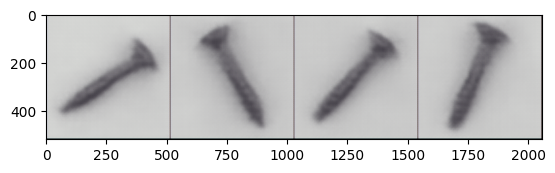


 EPOCH 13/50 	 train loss 0.002161510055884719 	 val loss 0.0021892767399549484


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


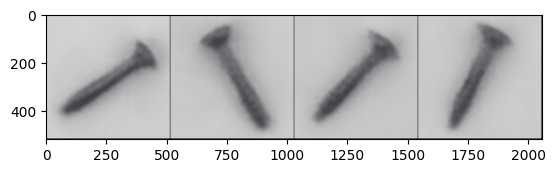


 EPOCH 14/50 	 train loss 0.0021645708475261927 	 val loss 0.0021440156269818544


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


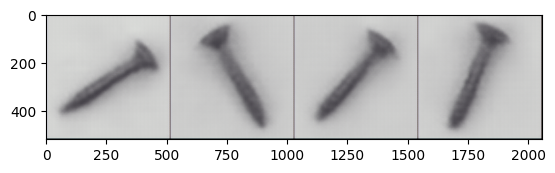


 EPOCH 15/50 	 train loss 0.002020913641899824 	 val loss 0.0019241943955421448


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


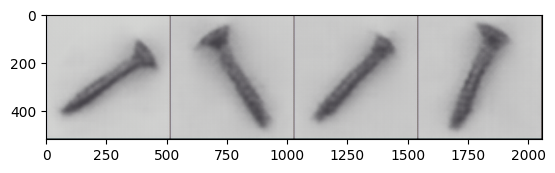


 EPOCH 16/50 	 train loss 0.0019703141879290342 	 val loss 0.0020647933706641197


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


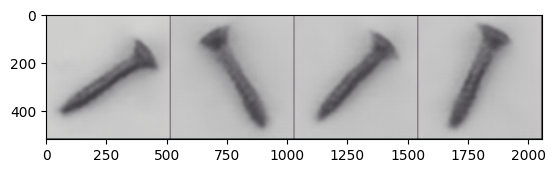


 EPOCH 17/50 	 train loss 0.0018806367879733443 	 val loss 0.0020850433502346277


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


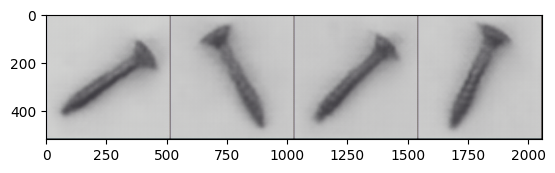


 EPOCH 18/50 	 train loss 0.0019028066890314221 	 val loss 0.0029778210446238518


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


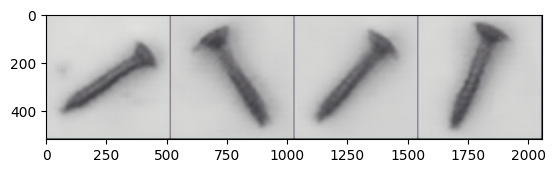


 EPOCH 19/50 	 train loss 0.0018787775188684464 	 val loss 0.0018713312456384301


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


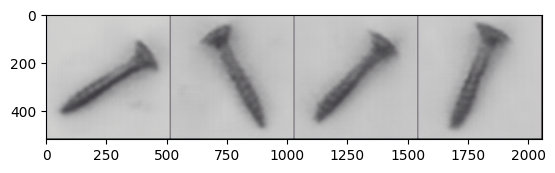


 EPOCH 20/50 	 train loss 0.0018244367092847824 	 val loss 0.002102510305121541


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


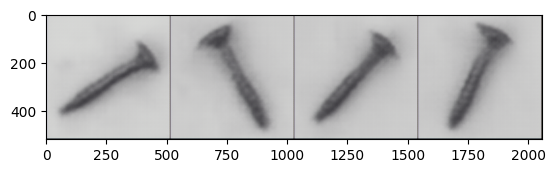


 EPOCH 21/50 	 train loss 0.0017189232166856527 	 val loss 0.0017461562529206276


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


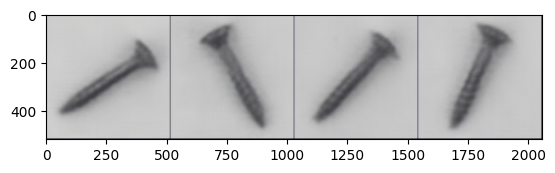


 EPOCH 22/50 	 train loss 0.0018435734091326594 	 val loss 0.0018864287994801998


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


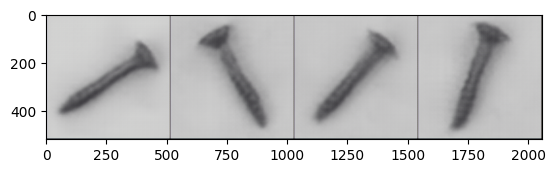


 EPOCH 23/50 	 train loss 0.0018034032545983791 	 val loss 0.00178601557854563


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


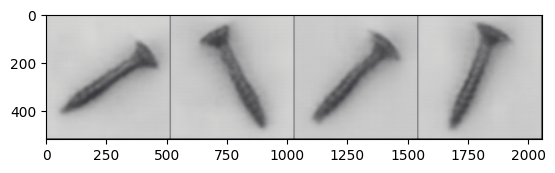


 EPOCH 24/50 	 train loss 0.0015959687298163772 	 val loss 0.0016900425544008613


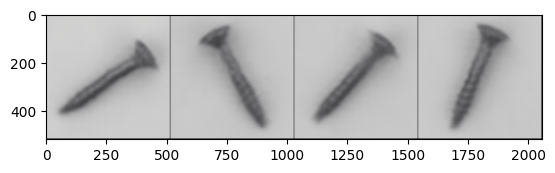


 EPOCH 25/50 	 train loss 0.0015973696717992425 	 val loss 0.002194202970713377


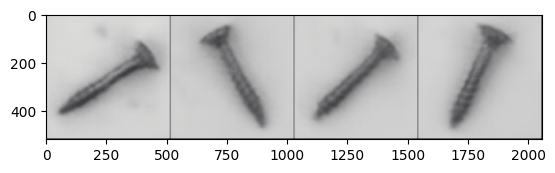


 EPOCH 26/50 	 train loss 0.0018200648482888937 	 val loss 0.0020807988476008177


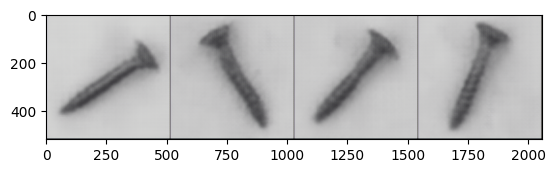


 EPOCH 27/50 	 train loss 0.0018195252632722259 	 val loss 0.0016465898370370269


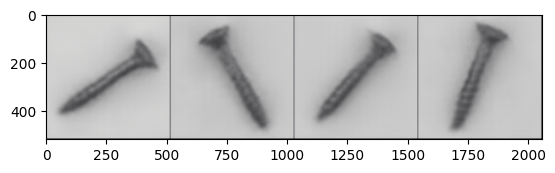


 EPOCH 28/50 	 train loss 0.0015934060793370008 	 val loss 0.001524450141005218


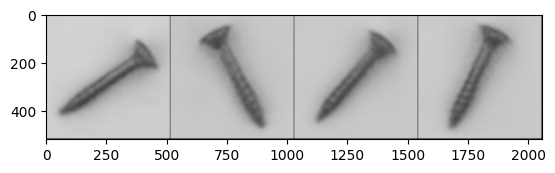


 EPOCH 29/50 	 train loss 0.0015648863045498729 	 val loss 0.0017344084335491061


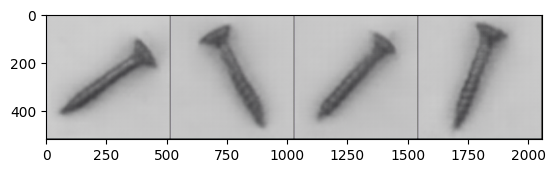


 EPOCH 30/50 	 train loss 0.0016168717993423343 	 val loss 0.0037158771883696318


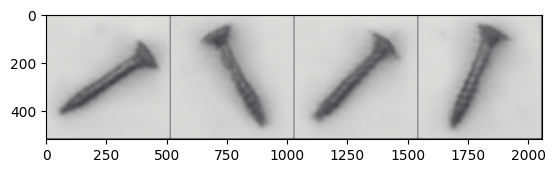


 EPOCH 31/50 	 train loss 0.001627366989850998 	 val loss 0.0015602769562974572


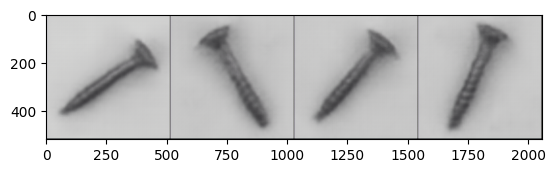


 EPOCH 32/50 	 train loss 0.001567769329994917 	 val loss 0.0014832750894129276


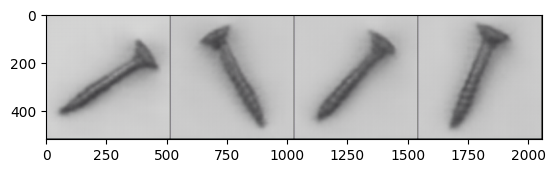


 EPOCH 33/50 	 train loss 0.001596176763996482 	 val loss 0.0014394990867003798


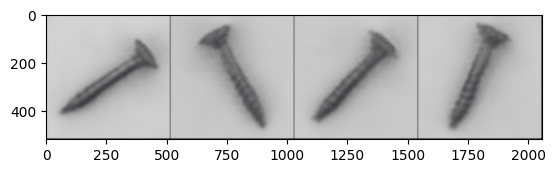


 EPOCH 34/50 	 train loss 0.0015480989823117852 	 val loss 0.0016972314333543181


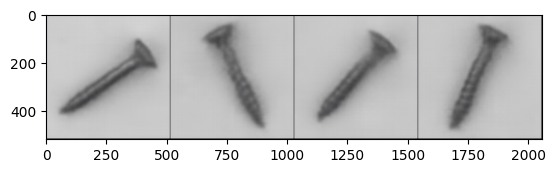


 EPOCH 35/50 	 train loss 0.0015640056226402521 	 val loss 0.0016520459903404117


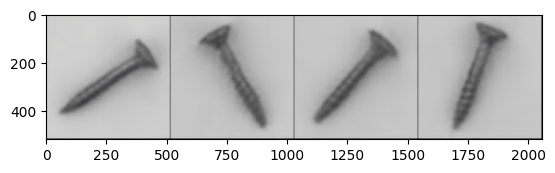


 EPOCH 36/50 	 train loss 0.0014939444372430444 	 val loss 0.001526270410977304


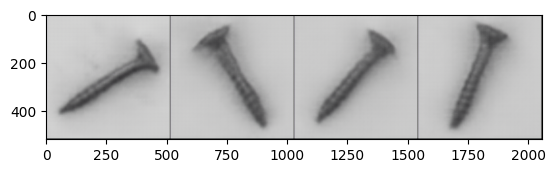


 EPOCH 37/50 	 train loss 0.001655405038036406 	 val loss 0.004289461765438318


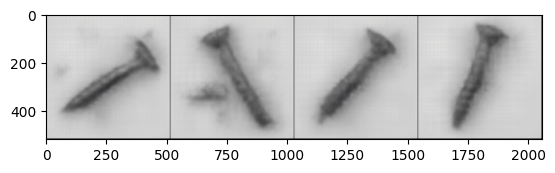


 EPOCH 38/50 	 train loss 0.002001076005399227 	 val loss 0.002031429437920451


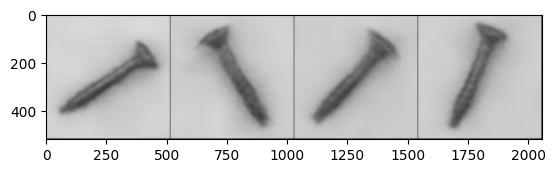


 EPOCH 39/50 	 train loss 0.0015331738395616412 	 val loss 0.0015894857933744788


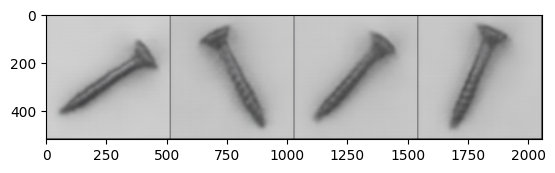


 EPOCH 40/50 	 train loss 0.0013973000459372997 	 val loss 0.0018031946383416653


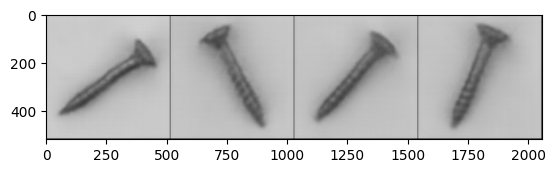


 EPOCH 41/50 	 train loss 0.0014593817759305239 	 val loss 0.0016086554387584329


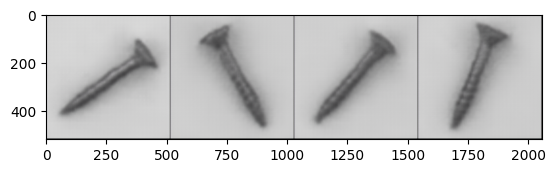


 EPOCH 42/50 	 train loss 0.001395057886838913 	 val loss 0.001601048861630261


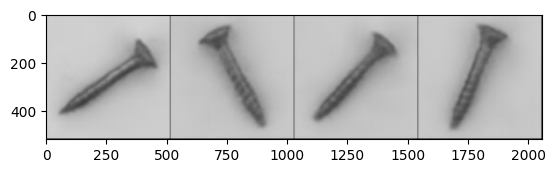


 EPOCH 43/50 	 train loss 0.0014930407050997019 	 val loss 0.001768499962054193


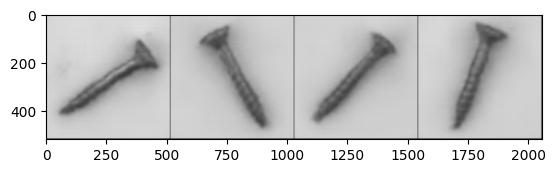


 EPOCH 44/50 	 train loss 0.0014334062580019236 	 val loss 0.0015429739141836762


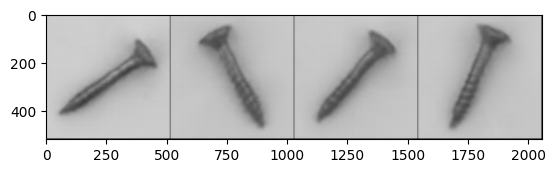


 EPOCH 45/50 	 train loss 0.0014004397671669722 	 val loss 0.001977497013285756


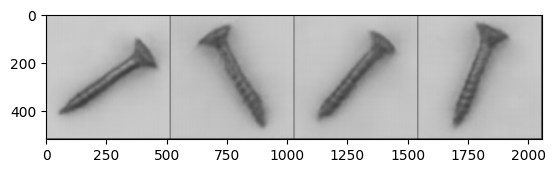


 EPOCH 46/50 	 train loss 0.0014673981349915266 	 val loss 0.006093701347708702


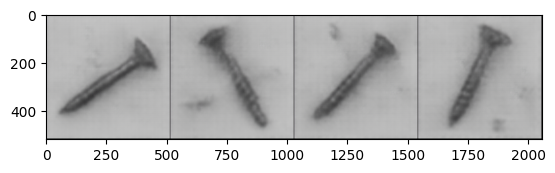


 EPOCH 47/50 	 train loss 0.0014269899111241102 	 val loss 0.001956129679456353


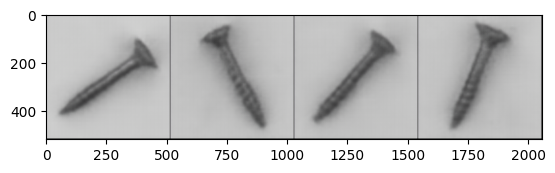


 EPOCH 48/50 	 train loss 0.0014163784217089415 	 val loss 0.0015060490695759654


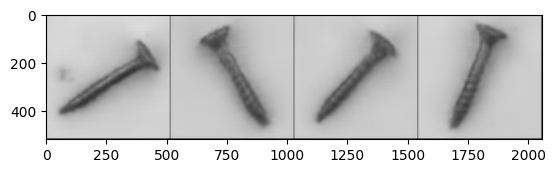


 EPOCH 49/50 	 train loss 0.0013946529943495989 	 val loss 0.001355262822471559


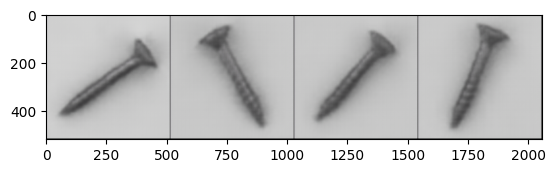


 EPOCH 50/50 	 train loss 0.001345890574157238 	 val loss 0.0017516970401629806


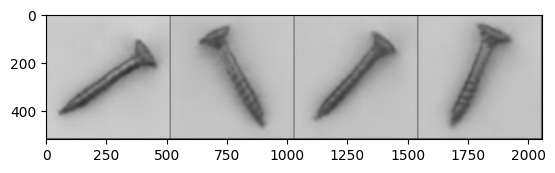

In [87]:
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(model,device,train_dataloader,loss,optim) # add scheduler
   val_loss = test_epoch(model,device,val_dataloader,loss)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(model,n=10)

Temp Section do not delete

torch.Size([1, 3, 512, 512])
tensor([[[[0.5249, 0.7223, 0.7112,  ..., 0.7336, 0.7300, 0.5959],
          [0.7138, 0.7564, 0.8445,  ..., 0.8272, 0.7214, 0.7227],
          [0.7837, 0.7994, 0.7766,  ..., 0.7679, 0.7803, 0.7361],
          ...,
          [0.7333, 0.8579, 0.7928,  ..., 0.7848, 0.8149, 0.7191],
          [0.7503, 0.7625, 0.8238,  ..., 0.8121, 0.7717, 0.7206],
          [0.5957, 0.7720, 0.6566,  ..., 0.7134, 0.6859, 0.4529]],

         [[0.5287, 0.7115, 0.7918,  ..., 0.7920, 0.8044, 0.6496],
          [0.6499, 0.7777, 0.7815,  ..., 0.7912, 0.7929, 0.6014],
          [0.7343, 0.7051, 0.7952,  ..., 0.8421, 0.8209, 0.6967],
          ...,
          [0.7338, 0.8034, 0.8229,  ..., 0.7899, 0.7979, 0.7661],
          [0.6994, 0.8137, 0.8259,  ..., 0.7259, 0.7757, 0.7747],
          [0.6087, 0.7233, 0.8327,  ..., 0.7237, 0.7318, 0.4411]],

         [[0.6104, 0.7270, 0.7397,  ..., 0.6769, 0.7745, 0.5187],
          [0.6842, 0.7940, 0.8364,  ..., 0.7663, 0.7809, 0.6393],
          [0.

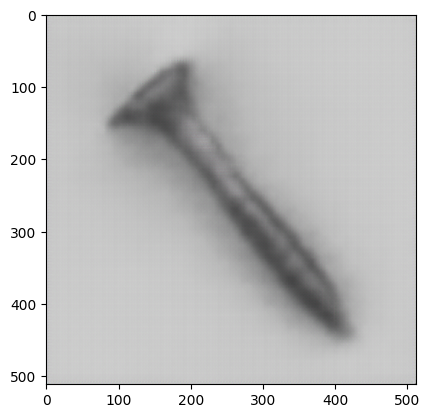

In [88]:
inputs = next(iter(test_dataloader))
inputs = inputs.to(device)
out = model(inputs)
print(out.shape)
out = out.cpu()
print(out)
out = torchvision.utils.make_grid(out)
out =  out.detach()
imshow(out)

Loss Plot

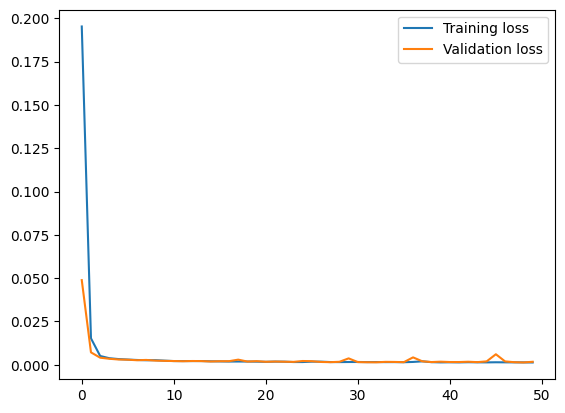

In [89]:
plt.plot(diz_loss['train_loss'],label='Training loss')
plt.plot(diz_loss['val_loss'],label='Validation loss')
plt.legend()
plt.show()

Latent Representation

In [90]:
train = []
val = []
test = []
data = []
with torch.no_grad():
        for image_batch in train_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            train.append(decoded_data.cpu())
            data.append(decoded_data.cpu())
        for image_batch in val_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            val.append(decoded_data.cpu())
            data.append(decoded_data.cpu())
        for image_batch in test_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            test.append(decoded_data.cpu())
            data.append(decoded_data.cpu())
        train = torch.cat(train)
        val = torch.cat(val)
        test = torch.cat(test)
        data = torch.cat(data)
torch.set_printoptions(threshold=10_000)

C:\Users\panch\AppData\Local\Temp\ipykernel_10632\472349920.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(train[:, 0], train[:, 1], train[:, 2],cmap='hot')
C:\Users\panch\AppData\Local\Temp\ipykernel_10632\472349920.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(val[:, 0], val[:, 1], val[:, 2],c='#FFA500', cmap='hot')
C:\Users\panch\AppData\Local\Temp\ipykernel_10632\472349920.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(test[:, 0], test[:, 1], test[:, 2],c='#00FF00', cmap='hot')


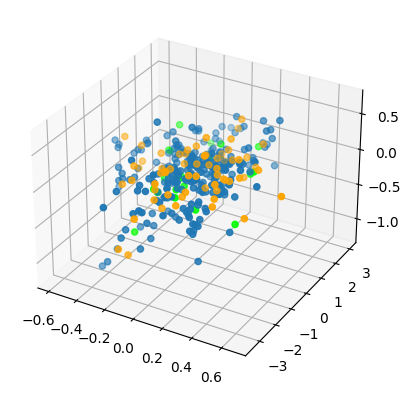

In [91]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(train[:, 0], train[:, 1], train[:, 2],cmap='hot')
ax.scatter(val[:, 0], val[:, 1], val[:, 2],c='#FFA500', cmap='hot')
ax.scatter(test[:, 0], test[:, 1], test[:, 2],c='#00FF00', cmap='hot')

# Display the plot
plt.show()

[2 1 1 1 1 0 1 2 2 0 1 2 1 2 1 2 2 1 2 2 1 1 2 2 2 2 2 1 2 1 2 2 1 0 1 2 2
 1 0 2 0 2 2 0 0 1 1 1 2 1 2 1 1 1 0 1 1 1 2 1 2 1 2 1 2 2 2 1 0 0 2 2 0 0
 2 0 2 2 1 1 2 2 1 1 1 1 0 2 1 2 0 1 1 0 2 1 1 1 1 1 1 1 1 2 2 1 1 2 1 2 1
 2 1 0 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 1 1 2 1 2 1 1 2 2 1 2 1 2 2 2 2 1 2 1
 1 1 2 1 2 1 2 2 1 2 2 1 1 1 2 2 2 1 1 2 1 0 1 1 1 2 1 2 2 1 1 2 0 1 1 2 1
 2 2 2 2 2 2 1 2 2 2 2 1 2 0 2 2 2 2 2 1 1 0 0 2 2 1 1 2 1 1 2 2 1 0 1 2 1
 2 0 2 1 2 1 0 1 2 2 2 1 2 2 1 1 0 1 1 2 2 1 2 2 2 2 2 1 1 2 1 0 1 2 2 1 1
 2 2 1 2 1 0 2 2 2 0 2 1 1 2 2 1 2 2 1 0 2 2 0 0 2 1 1 0 1 1 1 2 2 2 2 1 2
 2 2 1 1 0 1 2 1 1 1 2 1 2 1 0 1 2 0 2 2 2 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2]
[[-7.55984216e-02 -3.07163069e-01 -5.79553186e-03  1.18775880e+00
   2.23064561e+00  3.87163468e-01  2.28150918e+00  1.34270903e+00
  -8.30112601e-01  2.09996959e+00 -1.49584520e-01  1.47137806e+00
   1.95323159e+00 -6.73158351e-01  9.86435511e-01  1.11179864e-01
  -7.96766993e-03  1.39448557e-01 -3.

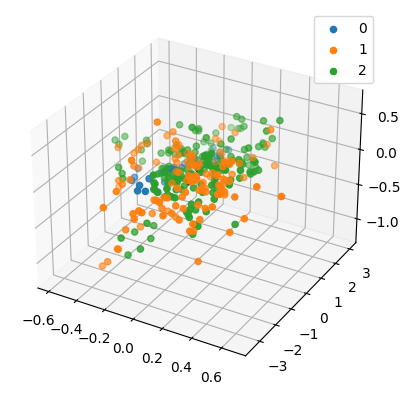

In [92]:
from sklearn import cluster
kmeans = cluster.KMeans(init='k-means++',n_clusters=3).fit(data)

labels = kmeans.labels_
print(labels)
centroids = kmeans.cluster_centers_
print(centroids)
u_labels = np.unique(labels)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in u_labels:
    ax.scatter(data[labels == i , 0] , data[labels == i , 1], data[labels == i , 2] , label = i)

ax.scatter(centroids[:,0] , centroids[:,1] , centroids[:,2], color = 'k')
plt.legend()
plt.show()



In [93]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, random_state=0).fit(data)
print(gm.means_)
print(gm.predict(test))

[[ 3.62313463e-02 -1.05010365e+00 -3.68627120e-02 -5.22881251e-01
   7.46605484e-01  3.08367246e-01  1.65451960e+00  4.14717216e-01
  -2.58908886e-01  4.67793734e-01 -1.03049526e-01  1.83041866e+00
  -1.07387472e+00 -2.09159862e+00  5.66744461e-02 -8.40443600e-04
  -3.53609856e-02 -1.84712710e-02 -8.30940269e-01  1.91057274e-01
   6.65892911e-01 -1.13204645e+00  1.39342915e-01  3.28230879e-03
  -2.72882915e-01  3.63309859e-01 -1.65433138e-01  2.02476491e-01
   4.57872098e-01 -4.46001305e-02 -9.22572722e-03  1.64486800e+00
  -3.48526351e-01 -2.03973900e-02 -1.25835551e+00 -7.73703122e-01
  -6.49175171e-01 -1.61236733e+00 -4.25510045e-03  2.78002290e-01]
 [-1.16399242e-01 -2.25237557e-01  4.62515552e-04 -1.08039648e+00
   1.39843794e+00  3.82690117e-01  2.37009886e+00  2.75604584e-01
   3.48950093e-02  1.13127736e+00  8.21628866e-02  1.18229458e+00
  -1.08142552e+00 -2.34238735e+00  7.51965435e-01 -1.42250261e-01
   7.21756341e-02 -5.33895180e-02 -1.72481711e-01  4.58294493e-01
   1.0331

Encoder-Decoder Output Loss Histogram

In [94]:
model.eval()
ms = []
kl_loss = nn.KLDivLoss(reduction = 'batchmean')
for image_batch in train_dataloader:
    image_batch = image_batch.to(device)
    decoded_data = model(image_batch)
    mse = kl_loss(decoded_data, image_batch).detach()
    ms.append(mse.cpu().detach().item())


print(ms)
hist, bins = np.histogram(ms, density=False)
print(hist)
print(bins)
#plt.hist(hist,bins = bins, density=False)
#ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.show()

[-585600.5625, -584956.875, -586709.25, -576126.125, -586653.75, -586308.375, -596623.0, -588930.0, -579045.375, -588092.375, -586653.6875, -577268.25, -589892.5, -577513.9375, -581238.625, -587375.4375, -588720.125, -607011.625, -578130.625, -589048.3125, -590271.4375, -582979.125, -582101.0, -582400.0, -578336.0, -586657.5625, -585081.5, -576913.5, -589810.875, -590614.125, -588941.0, -598516.875, -584512.375, -578877.5, -591345.3125, -591634.125, -588964.8125, -579544.9375, -584127.875, -583956.5625, -588467.875, -583802.6875, -575949.4375, -585145.125, -596735.875, -581448.875, -591647.6875, -588941.875, -598216.25, -591861.75, -596462.25, -580684.4375, -589325.0, -584576.6875, -580256.4375, -593376.9375, -589643.4375, -584654.25, -592787.3125, -584142.3125, -591114.5, -603106.625, -586208.25, -582182.125]
[ 1  1  2  3  5 15  9 13  6  9]
[-607011.625   -603905.40625 -600799.1875  -597692.96875 -594586.75
 -591480.53125 -588374.3125  -585268.09375 -582161.875   -579055.65625
 -57594

t-SNE Plot

In [95]:
# Generate random data with 512*512*20 features
# data = np.random.randn(1000, 512*512*20)
data = train
# Perform t-SNE on the data
tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(data)

# Plot the results
plt.scatter(data_tsne[:,0], data_tsne[:,1])
plt.title("t-SNE Plot")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'